In [9]:
!pip install scikeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 64.2 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
def load_data(path):
    df = pd.read_csv(path)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols]=df[numeric_cols].round(2)
    X = df.drop(columns=["Label"]).replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean()).values

    y = df["Label"].astype(str).values
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    num_classes = len(np.unique(y))
    y = to_categorical(y, num_classes=num_classes)
    return X, y,num_classes

In [85]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=128, kernel_size=16, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(64, dropout=0.1),
        Dense(num_classes, activation="sigmoid")
    ])

    if num_classes>2:
        entropy = "categorical_crossentropy"
    else:
        entropy = "binary_crossentropy"

    model.compile(
        optimizer="adam",
        loss=entropy,
        metrics=["accuracy"]
    )
    return model

In [86]:
def cnn_pipeline(path):
    X, y, num_classes = load_data(path)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    X_train, X_comb, y_train, y_comb = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=10
    )

    X_val, X_final_test, y_val, y_final_test = train_test_split(
        X_comb, y_comb, test_size=0.5, shuffle=True, random_state=10
    )

    keras_clf = KerasClassifier(
        model=build_model,
        input_shape=(X.shape[1], 1),
        num_classes=num_classes,
        epochs=20,
        batch_size=128,
        verbose=1
    )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", keras_clf)
    ])

    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
    pipeline.named_steps['scaler'].fit(X_train_2d)
    X_train_scaled = pipeline.named_steps['scaler'].transform(X_train_2d)
    X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)

    X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1])
    X_val_scaled = pipeline.named_steps['scaler'].transform(X_val_2d)
    X_val_scaled = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], 1)

    X_final_test_2d = X_final_test.reshape(X_final_test.shape[0], X_final_test.shape[1])
    X_final_test_scaled = pipeline.named_steps['scaler'].transform(X_final_test_2d)
    X_final_test_scaled = X_final_test_scaled.reshape(X_final_test.shape[0], X_final_test.shape[1], 1)

    history = pipeline.named_steps['model'].fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val)
    )

    accuracy = pipeline.named_steps['model'].score(X_final_test_scaled, y_final_test)
    print("Final Test Accuracy:", accuracy)

    history = pipeline.named_steps['model'].history_
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


    return pipeline, accuracy


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


514/514 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5433 - loss: 1.1847 - val_accuracy: 0.8602 - val_loss: 0.3540
Epoch 2/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8739 - loss: 0.3335 - val_accuracy: 0.9264 - val_loss: 0.1992
Epoch 3/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9174 - loss: 0.2242 - val_accuracy: 0.9439 - val_loss: 0.1528
Epoch 4/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9334 - loss: 0.1825 - val_accuracy: 0.9513 - val_loss: 0.1294
Epoch 5/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9414 - loss: 0.1582 - val_accuracy: 0.9552 - val_loss: 0.1169
Epoch 6/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9462 - loss: 0.1442 - val_accuracy: 0.9556 - val_loss: 0.1144
Epoch 7/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9471 - loss: 0.1344 - val_accuracy: 0.9532 - val_loss: 0.1223
Epoch 8/20
514/514 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9537 - loss: 0.1235 - val_accurac

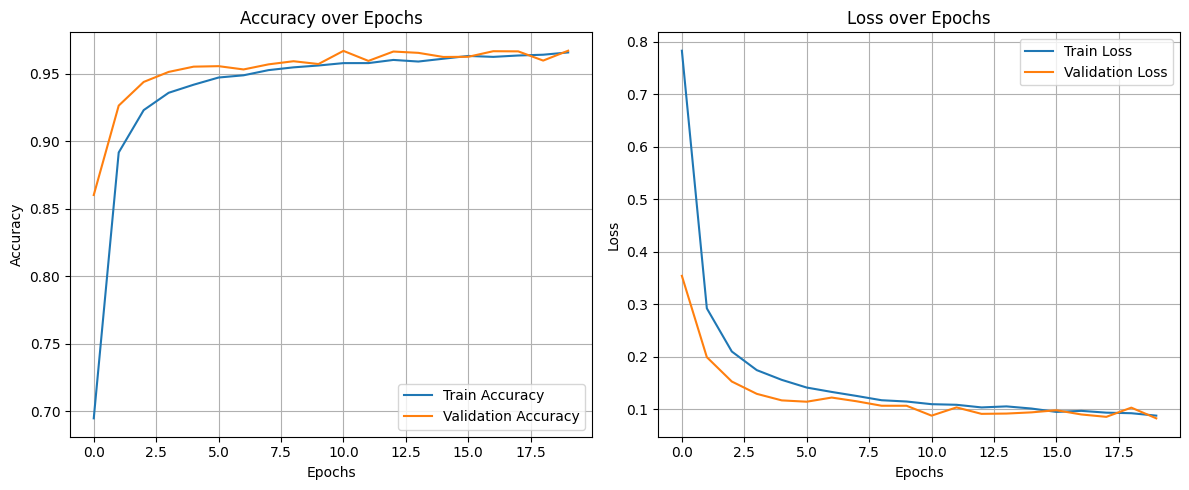

Final Test Accuracy: 0.967639902676399


In [93]:
path = r"/kaggle/input/classwise-balanced-ciciot-2023/ClassWise_Labeled_Balanced_Dataset.csv"

model,acc = cnn_pipeline(path)
print("Final Test Accuracy:", acc)

0.1 lstm drop out : accuracy = 94.0<br>
0.3 lstm drop out : accuracy = 91.26

conv filter = 32 : 94.8<br>
conv filter = 64 : 95.1<br>
conv filter = 128 : 95.40

kernel size : 12 = 95.67<br>
kernel size : 16 = 96.1

***Binary classified data:***

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 186s 21ms/step - accuracy: 0.9137 - loss: 0.2175 - val_accuracy: 0.9262 - val_loss: 0.1828
Epoch 2/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 180s 21ms/step - accuracy: 0.9265 - loss: 0.1827 - val_accuracy: 0.9295 - val_loss: 0.1742
Epoch 3/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 180s 21ms/step - accuracy: 0.9292 - loss: 0.1754 - val_accuracy: 0.9316 - val_loss: 0.1717
Epoch 4/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 182s 21ms/step - accuracy: 0.9309 - loss: 0.1716 - val_accuracy: 0.9315 - val_loss: 0.1713
Epoch 5/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 180s 21ms/step - accuracy: 0.9310 - loss: 0.1707 - val_accuracy: 0.9332 - val_loss: 0.1668
Epoch 6/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 178s 21ms/step - accuracy: 0.9315 - loss: 0.1695 - val_accuracy: 0.9337 - val_loss: 0.1662
Epoch 7/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 178s 21ms/step - accuracy: 0.9322 - loss: 0.1682 - val_accuracy: 0.9345 - val_loss: 0.1644
Epoch 8/20
8587/8587 ━━━━━━━━━━━━━━━━━━━━ 180s 21ms/step - accuracy: 

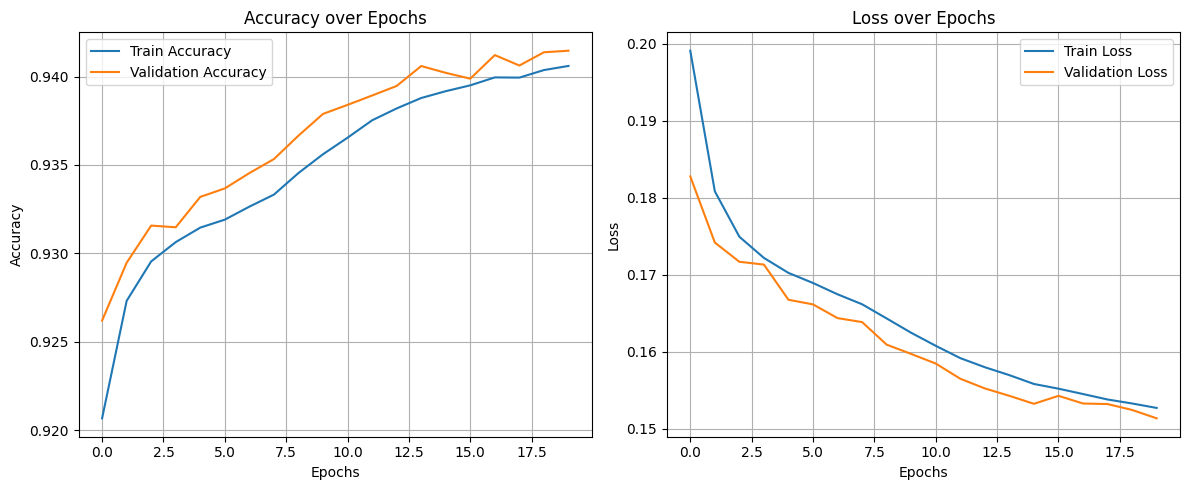

Final Test Accuracy: 0.9405466390071696


In [92]:
path = r"/kaggle/input/binary-classified-ciciot-2023-dataset/EqualBinaryData_CICIoT_2023 (1).csv"

model,acc = cnn_pipeline(path)
print("Final Test Accuracy:", acc)
